<a href="https://colab.research.google.com/github/Userfound404/MachineLearning-101/blob/main/MalariaFunctionalAPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Layer, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling, RandomContrast
from tensorflow.keras.models import Model
from keras.engine.input_layer import InputLayer, Input
from tensorflow.keras.metrics import Accuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, BinaryAccuracy
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
from google.colab import drive

In [ ]:
dataset, dataset_info = tfds.load('malaria', with_info=True,
                                  as_supervised=True,
                                  shuffle_files = True,
                                  split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteSRG5LL/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [ ]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [ ]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO )
#print(list(train_dataset.take(1).as_numpy_iterator()),
 #     list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))

In [ ]:
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
IM_SIZE =  224
BATCH_SIZE = 32

In [ ]:
original_image, label = next(iter(train_dataset))
@tf.function
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

_, _ = resize_rescale(original_image, label)
_, _ = resize_rescale(original_image, label)

In [ ]:
@tf.function
def augment(image, label):
  image, label = resize_rescale(image, label)

  image = tf.image.rot90(image)
  #image = tf.image.adjust_saturation(image, saturation_factor = 0.3)
  image = tf.image.flip_left_right(image)

  return image, label

In [ ]:
class RotNinety(Layer):
  def __init__(self):
    super().__init__()

  @tf.function
  def call(self, image):
    return tf.image.rot90(image)

In [ ]:
resize_rescale_layers = tf.keras.Sequential([
       Resizing(IM_SIZE, IM_SIZE),
       Rescaling(1./255),
])

In [ ]:
augment_layers = tf.keras.Sequential([
       RandomRotation(factor = (0.25, 0.2501),),
       RandomFlip(mode='horizontal',),
       RandomContrast(factor=0.1),

])

@tf.function
def augment_layer(image, label):
  return augment_layers(resize_rescale_layers(image), training = True), label

In [ ]:
test_dataset = test_dataset.map(resize_rescale, num_parallel_calls = tf.data.AUTOTUNE)

In [ ]:
test_dataset

<_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
train_dataset = (
    train_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
val_dataset = (
    val_dataset
    .shuffle(buffer_size = 32)
    .map(resize_rescale, num_parallel_calls = tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
)

In [ ]:

def resizing_rescale(image, label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE), method=tf.image.ResizeMethod.BILINEAR)/255.0, label

In [ ]:
# train_dataset = train_dataset.map(resizing_rescale)
# val_dataset = val_dataset.map(resizing_rescale)
# test_dataset = test_dataset.map(resizing_rescale, num_parallel_calls = tf.data.AUTOTUNE).batch(BATCH_SIZE)
# train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
from keras.engine.input_layer import InputLayer
Lunette_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),
    Conv2D(filters = 6, kernel_size = 5, strides = 1, padding = 'valid', activation = 'sigmoid'),
    MaxPool2D(pool_size = 2, strides = 2),
    Conv2D(filters = 16, kernel_size = 5, strides = 1, padding = 'valid', activation = 'sigmoid'),
    MaxPool2D(pool_size = 2, strides = 2),

    Flatten(),
    Dense(100, activation = 'sigmoid'),
    Dense(10, activation = 'sigmoid'),
    Dense(1, activation = 'sigmoid'),
])
Lunette_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 6)       456       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 16)      2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 44944)             0         
                                                                 
 dense (Dense)               (None, 100)               4

In [ ]:
Lunette_model_modified = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),
    Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Flatten(),
    Dense(100, activation = 'relu'),
    BatchNormalization(),

    Dense(10, activation = 'relu'),
    BatchNormalization(),
    Dense(1, activation = 'sigmoid'),
])
Lunette_model_modified.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 6)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                      

In [ ]:
func_input = Input( shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = 2, strides = 2)(x)

x = Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = 2, strides = 2)(x)

x = Flatten()(x)
x = Dense(100, activation = 'relu')(x)
x = BatchNormalization()(x)

x = Dense(10, activation = 'relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation = 'sigmoid')(x)

lenette_model_functionalAPI = Model(func_input, func_output, name = "lenette_model_functionalAPI" )
lenette_model_functionalAPI.summary()

Model: "lenette_model_functionalAPI"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Batc  (None, 222, 222, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 6)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Batc  (None, 10

In [ ]:
lenette_model_functionalAPI.compile(optimizer = Adam(learning_rate = 0.01),
                               loss = BinaryCrossentropy(),
                               metrics = 'accuracy',)

In [ ]:
# history = lenette_model_functionalAPI.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1)

In [ ]:
#callable models
func_input = Input( shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = 2, strides = 2)(x)

x = Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size = 2, strides = 2)(x)


Feature_extractor_model_functionalAPI = Model(func_input, output, name = "Feature_Extractor" )
Feature_extractor_model_functionalAPI.summary()

Model: "Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 6)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 16

In [ ]:
#callable models
func_input = Input( shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

#even sequential models can be called
x = Feature_extractor_model_functionalAPI(func_input)

x = Flatten()(x)
x = Dense(100, activation = 'relu')(x)
x = BatchNormalization()(x)

x = Dense(10, activation = 'relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation = 'sigmoid')(x)

lenette_model_functionalAPI_FeatureExtractor = Model(func_input, func_output, name = "lenette_model_functionalAPI_FeatureExtractor" )
lenette_model_functionalAPI_FeatureExtractor.summary()

Model: "lenette_model_functionalAPI_FeatureExtractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Feature_Extractor (Function  (None, 54, 54, 16)       1136      
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 46656)             0         
                                                                 
 dense (Dense)               (None, 100)               4665700   
                                                                 
 batch_normalization_2 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)      

In [ ]:
#model subclassing
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size,):
    super(FeatureExtractor, self).__init__()

    self.conv_1 = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding , activation= activation)(func_input)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D(pool_size = pool_size, strides = 2*strides)

    self.conv_2 = Conv2D(filters = filters*2, kernel_size = kernel_size, strides = strides, padding = padding , activation= activation)(func_input)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D(pool_size = pool_size, strides = 2*strides)

  def call(self, x, training):

    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x

feature_sub_class = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

In [ ]:
#callable models
func_input = Input( shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

#even sequential models can be called
x = FeatureExtractor(func_input)

x = Flatten()(x)
x = Dense(100, activation = 'relu')(x)
x = BatchNormalization()(x)

x = Dense(10, activation = 'relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation = 'sigmoid')(x)

lenette_model_functionalAPI_FeatureExtractor = Model(func_input, func_output, name = "lenette_model_functionalAPI_FeatureExtractor" )
lenette_model_functionalAPI_FeatureExtractor.summary()

In [ ]:
#custom layer
class NewDense(Layer): #inherit layer class
  def __init__(self, output_units, activation):
    super(NewDense, self).__init__()
    self.output_units = output_units
    self.activation = activation

  def build(self, input_features_shape):
    self.w = self.add_weight(shape = (input_features_shape[-1], self.output_units), initializer = "glorot_uniform", trainable = True)
    self.b = self.add_weight(shape = (self.output_units,), initializer = "zeros", trainable = True)

  def call(self, input_features):
    pre_output = tf.matmul(input_features, self.w) + self.b
    if(self.activation == "relu"):
      return tf.nn.relu(pre_output)
    elif(self.activation == "sigmoid"):
      return tf.math.sigmoid(pre_output)
    else:
      return pre_output

In [ ]:
Lunette_model_Customlayer = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),
    Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Flatten(),
    NewDense(100, activation = 'relu'),
    BatchNormalization(),

    NewDense(10, activation = 'relu'),
    BatchNormalization(),
    NewDense(1, activation = 'sigmoid'),
])
Lunette_model_Customlayer.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                      

In [ ]:
Lunette_model_Customlayer.compile(optimizer = Adam(learning_rate = 0.01),
                               loss = BinaryCrossentropy(),
                               metrics = 'accuracy',)

In [ ]:
history = Lunette_model_Customlayer.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1)

Epoch 1/5
689/689 [==============================] - 147s 194ms/step - loss: 0.3944 - accuracy: 0.8209 - val_loss: 0.3225 - val_accuracy: 0.9103
Epoch 2/5
689/689 [==============================] - 141s 204ms/step - loss: 0.2224 - accuracy: 0.9265 - val_loss: 0.3099 - val_accuracy: 0.9394
Epoch 3/5
689/689 [==============================] - 134s 194ms/step - loss: 0.2141 - accuracy: 0.9277 - val_loss: 0.9634 - val_accuracy: 0.8486
Epoch 4/5
689/689 [==============================] - 142s 206ms/step - loss: 0.2026 - accuracy: 0.9333 - val_loss: 0.5660 - val_accuracy: 0.7539
Epoch 5/5
689/689 [==============================] - 134s 194ms/step - loss: 0.2263 - accuracy: 0.9249 - val_loss: 0.4085 - val_accuracy: 0.8250


In [ ]:
#model evaluation
# TP|FP
# FN|TN

# True Positive = Both prediction and label is true
# False Positive = Prediction is true but label is false ~ should avoid(2) - type1 error
# False Negetive = Prediction is false but label is true ~ should avoid(1) - type2 error
# True Negetive = Both prediction and label is false

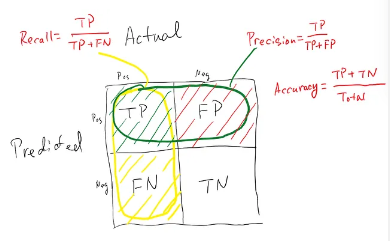

Precision = $ \frac{(TP)}{(TP + FP)} $

Recall = $\frac {TP}{(TP + FN)}$

Accuracy = $\frac {TN + TP}{TN + TP + FN + FP}$

F1 score = $\frac{2.P.R}{P + R}$

Specificity = $\frac{TN}{TN+FP}$


An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

- True Positive Rate
- False Positive Rate

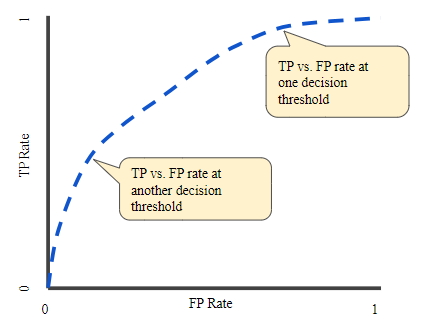

AUC stands for "Area under the ROC Curve."

In [ ]:
metrics = [TruePositives(name = 'tp'), FalsePositives(name = 'fp'), FalseNegatives(name = 'fn'), BinaryAccuracy(name = 'accuracy'), TrueNegatives(name ='tn'), Precision(name= 'precision'), Recall(name = 'recall'), AUC(name ='auc')]

In [ ]:
Lunette_model_Customlayer.compile(optimizer = Adam(learning_rate = 0.01),
                               loss = BinaryCrossentropy(),
                               metrics = metrics,)

In [ ]:
history = Lunette_model_Customlayer.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1)

Epoch 1/5
689/689 [==============================] - 154s 202ms/step - loss: 0.3710 - tp: 9414.0000 - fp: 2024.0000 - fn: 1609.0000 - accuracy: 0.8352 - tn: 8999.0000 - precision: 0.8230 - recall: 0.8540 - auc: 0.9147 - val_loss: 0.2642 - val_tp: 1355.0000 - val_fp: 183.0000 - val_fn: 41.0000 - val_accuracy: 0.9187 - val_tn: 1176.0000 - val_precision: 0.8810 - val_recall: 0.9706 - val_auc: 0.9584
Epoch 2/5
689/689 [==============================] - 139s 201ms/step - loss: 0.1985 - tp: 10423.0000 - fp: 878.0000 - fn: 602.0000 - accuracy: 0.9329 - tn: 10143.0000 - precision: 0.9223 - recall: 0.9454 - auc: 0.9706 - val_loss: 0.1973 - val_tp: 1341.0000 - val_fp: 110.0000 - val_fn: 57.0000 - val_accuracy: 0.9394 - val_tn: 1247.0000 - val_precision: 0.9242 - val_recall: 0.9592 - val_auc: 0.9768
Epoch 3/5
689/689 [==============================] - 138s 200ms/step - loss: 0.1904 - tp: 10474.0000 - fp: 827.0000 - fn: 551.0000 - accuracy: 0.9375 - tn: 10194.0000 - precision: 0.9268 - recall: 0.9

In [ ]:
test_dataset = test_dataset.batch(1)

In [ ]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
Lunette_model_Customlayer.evaluate(test_dataset)

2757/2757 [==============================] - 27s 5ms/step - loss: 0.1894 - tp: 1319.0000 - fp: 122.0000 - fn: 42.0000 - accuracy: 0.9405 - tn: 1274.0000 - precision: 0.9153 - recall: 0.9691 - auc: 0.9766


[0.18935498595237732,
 1319.0,
 122.0,
 42.0,
 0.9405150413513184,
 1274.0,
 0.915336549282074,
 0.969140350818634,
 0.9765734076499939]

In [ ]:
#confusion matrix
labels = []
inputs = []

for x, y in test_dataset.as_numpy_iterator():
  labels.append(y)
  inputs.append(x)

In [ ]:
labels = np.array([i[0] for i in labels])
print(labels)

[1 1 0 ... 1 1 0]


In [ ]:
print(np.array(inputs).shape)
print(np.array(inputs)[:, 0,...].shape)

(2757, 1, 224, 224, 3)
(2757, 224, 224, 3)


In [ ]:
predicted = Lunette_model_Customlayer.predict(np.array(inputs)[:,0,...])
print(predicted[:,0])
print(predicted)

87/87 [==============================] - 1s 14ms/step
[[0.98406214]
 [0.97336394]
 [0.04243748]
 ...
 [0.98595375]
 [0.9828468 ]
 [0.00533946]]


[[1300   93]
 [  57 1307]]


Text(0.5, 58.7222222222222, 'Predicted')

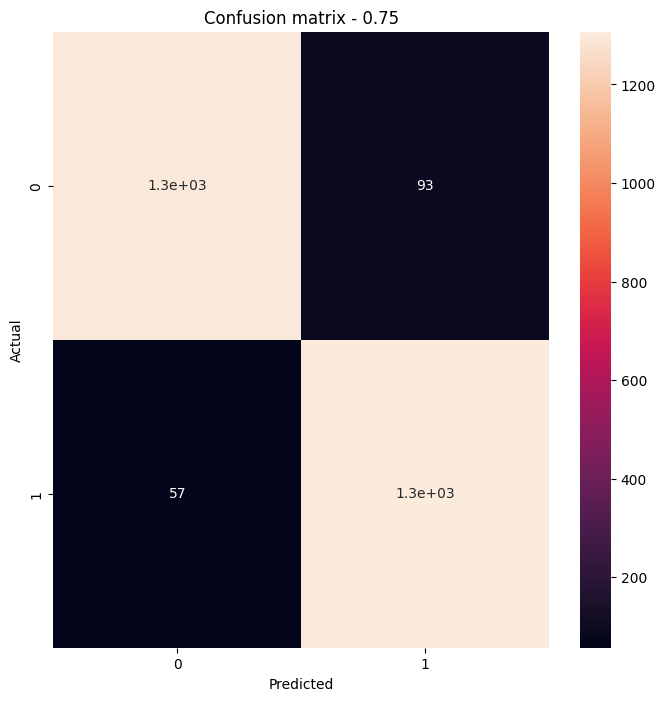

In [ ]:
threshold = 0.75

cm = confusion_matrix(labels, predicted > threshold)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')


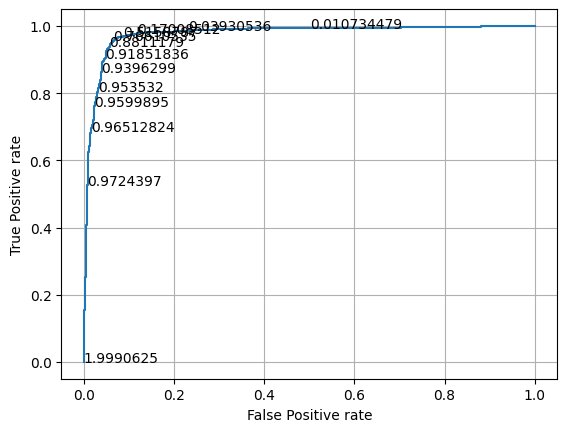

In [ ]:
fp, tp, thresholds = roc_curve(labels, predicted)
plt.plot(fp, tp)
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")

plt.grid()

skip = 20

for i in range(0, len(thresholds), skip):
  plt.text(fp[i], tp[i], thresholds[i])

plt.show()